$$
\textbf{Lógica Computacional: 2020/2021}\qquad
\textbf{Trabalho 1}\qquad
\scriptsize{Gilberto \, Cunha \quad Tomás \, Carneiro}
$$

# Problema 1

In [2]:
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import numpy as np
from z3 import *
import time

In [3]:
def all_simple_edges(G_in, source,target):
    paths = list(nx.all_simple_paths(G_in, source=source, target=target))
    edges = [[(paths[i][j-1], paths[i][j]) for j in range(1, len(paths[i]))] for i in range(len(paths))]
    return edges

## Gerar grafo $G$ aleatóriamente

Para gerar o grafo de input $G$ conectado, dado o número de vértices $n$, são executados os seguintes passos:
1. Para cada vértice definir um número aleatório de descendentes $n_d \in \{1, 2, \ldots, d\}$
2. Criar arestas originadas nesse vértice a $n_d$ vértices aleatórios, excluindo o próprio
3. Após esta tarefa ser executada para todos os vértices, verificar se o grafo $G$ é conectado usando a função `is_strongly_connected` do `networkx`
4. Caso não seja, apagar todas as arestas e voltar ao passo 1

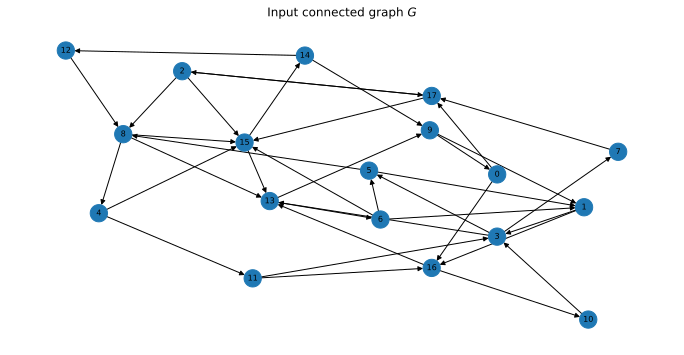

In [17]:
n, d = 18, 4

while True:
    G = nx.DiGraph()
    G.add_nodes_from([i for i in range(n)])
    for i in range(n):
        avail_nodes = [j for j in range(n) if j!=i]
        d_i = np.random.randint(1, d)
        np.random.shuffle(avail_nodes)
        edges = [(i, avail_nodes[j]) for j in range(d_i)]
        G.add_edges_from(edges)
    if nx.is_strongly_connected(G):
        break
        
# Plot do grafo de input
f = plt.figure(figsize=(12, 6))
plt.title("Grafo $G$ gerado aleatóriamente")
pos = nx.nx_pydot.graphviz_layout(G)
pos = nx.nx_pydot.graphviz_layout(G, prog="fdp")
nx.draw(G, font_size=8, pos=pos, with_labels=True)
plt.show()

É dado um grafo de input conectado $G = \langle \mathcal{V}, \mathcal{E} \rangle$.

Queremos determinar um subgrafo de $\mathcal{H = \langle \mathcal{V}, \mathcal{E'} \rangle}$, minimizando $|\mathcal{E'}|$ tal que este continue a ser conectado.

## Definir as condições que permitem deduzir $\mathcal{H}$ no Z3

Ambos $G$ e $\mathcal{H}$ podem ser representados por uma matriz de arestas $A$ e $B$, respetivamente, onde os elementos $A_{ij}, B_{ij} \in \{0, 1\}$ representam a existência de uma aresta orientada do vértice $n_i$ ao vértice $n_j$.

1. Para uma dada aresta pertencer a $\mathcal{H}$, então também deve pertencer a $G$:

$$ \forall_{\langle n_i, n_j \rangle \in G}, \quad 0 \le B_{ij} \le A_{ij} $$

Para cada par de vértices $\langle n_i, n_j \rangle \in G$ existe um conjunto de caminhos sem loops $S \equiv \{S_k\}$ que liga $n_i$ a $n_j$. A função `all_simple_paths` da biblioteca `networkx` do python permite determinar este conjunto $S$.

Para um dado caminho $S_k$ existir, então:

$$\prod_{\langle n_w, n_z \rangle \in S_k} B_{w, z} = 1 $$

2. Existe sempre um caminho $S_k \in S$, com $S$ o conjunto de caminhos entre cada par de vértices do grafo $\langle n_i, n_j \rangle \in G$:

$$ \forall_{\langle n_i, n_j \rangle \in G}, \sum_{S_k \in S} \left( \prod_{\langle n_w, n_z \rangle \in S_k} B_{w, z} \right) \ge 1 $$

3. Devemos então minimizar o número de arestas em $\mathcal{H}$:

$$ minimize \sum_{i=0}^{V-1} \sum_{j=0}^{V-1} B_{ij} $$

In [7]:
def get_subgraph(G_in):
    solver = Optimize()
    B = {(i, j): Int(f'{i},{j}') for i in range(len(G_in.nodes())) for j in range(len(G_in.nodes()))}
    
    # Pertence ao grafo original
    for i in range(len(G_in.nodes())):
        for j in range(len(G_in.nodes())):
            if (i,j) in G_in.edges:
                A_ij = 1
            else:
                A_ij = 0
            solver.add(B[i,j]>=0, B[i,j]<=A_ij)
            
    # Deve haver sempre um caminho entre um descendente e o seu destino
    for i in G_in.nodes:
        for j in G_in.nodes:
            if i != j:
                S = all_simple_edges(G_in, i, j)
                soma = Sum([Product([B[w,z] for (w,z) in S_k]) for S_k in S])
                solver.add(soma >= 1)

    # Minimizar o número de arestas
    obj = solver.minimize(Sum([B[i,j] for i in range(len(G_in.nodes())) for j in range(len(G_in.nodes()))]))

    # Verificar a satisfazibilidade
    if solver.check() == sat:
        print ("The maximum number of removable edges is", len(G_in.edges) - int(str(solver.lower(obj))))
        m = solver.model()
        rem_edges = [(i,j) for i,j in G_in.edges if m[B[i,j]]==0]
        r = nx.DiGraph.copy(G_in)
        r.remove_edges_from(rem_edges)
    else:
        r = None
        
    return r

## Determinar a solução $\mathcal{H}$

In [18]:
H = get_subgraph(G)

# Verificar que não existe nenhuma aresta em H que não exista em G
count = sum([1 for edge in H.edges if edge not in G.edges])
if count >= 1:
    print ("\nThere are edges in H that are not present in G")
else:
    print ("\nAll edges in H are present in G")
    
# Verificar que G e H têm o mesmo número de nodos
if len(H.nodes) == len(G.nodes):
    print ("G and H have the same number of nodes\n")
else:
    print ("G and H do not have the same number of nodes\n")
   
# Verificar que o grafo gerádo é conectado
assert nx.is_strongly_connected(H)
    
# Verificar que não pode ser removida nenhuma aresta
edges = list(H.edges)
for i, j in tqdm(edges, total=len(edges), desc=f"Checking for removable edges"):
    H.remove_edges_from([(i,j)])
    assert nx.is_strongly_connected(H) == False
    H.add_edges_from([(i,j)])
print ("No edge can be removed from the graph!")

Checking for removable edges: 100%|██████████| 20/20 [00:00<00:00, 11147.65it/s]

The maximum number of removable edges is 17

All edges in H are present in G
G and H have the same number of nodes

No edge can be removed from the graph!


## Plot das arestas removidas a $G$ 

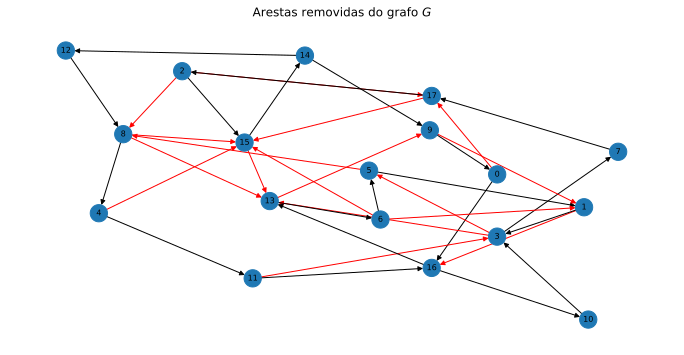

In [20]:
f = plt.figure(figsize=(12, 6))

# Pintar as arestas removidas a vermelho
edge_colors = []
for edge in G.edges:
    if edge not in H.edges:
        edge_colors.append("red")
    else:
        edge_colors.append("black")

# Plot do grafo de input
plt.title("Arestas removidas do grafo $G$")
pos = nx.nx_pydot.graphviz_layout(G)
pos = nx.nx_pydot.graphviz_layout(G, prog="fdp")

nx.draw(G, font_size=8, pos=pos, edge_color=edge_colors, with_labels=True)
plt.show()

## Dar plot a um caminho entre um par aleatório $\langle n_i, n_j \rangle$

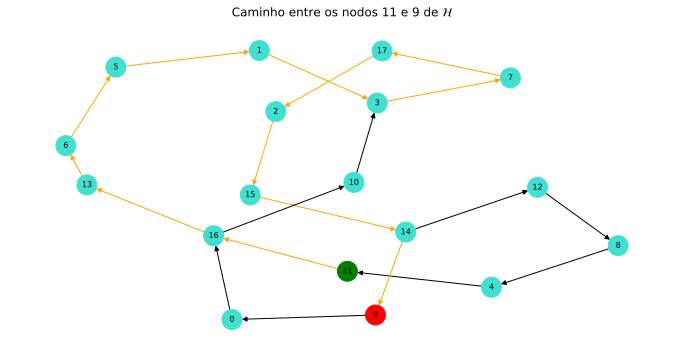

In [28]:
f = plt.figure(figsize=(12, 6))

# Gerar um par de nodos aleatóriamente
i = np.random.randint(len(G.nodes))
while True:
    j = np.random.randint(len(G.nodes))
    if j != i:
        break

# Pintar as arestas desse caminho a laranja
path = all_simple_edges(H, i, j)[0]
edge_colors = []
for edge in H.edges:
    if edge in path:
        edge_colors.append("orange")
    else:
        edge_colors.append("black")
        
# Pintar o nodo inicial de verde e o nodo final de vermelho
node_colors = []
for node in H.nodes:
    if node == i:
        node_colors.append("green")
    elif node == j:
        node_colors.append("red")
    else:
        node_colors.append("turquoise")
        
# Plot do grafo de input
plt.title("Caminho entre os nodos " + str(i) + " e " + str(j) + " de $\mathcal{H}$")
pos = nx.nx_pydot.graphviz_layout(H)
pos = nx.nx_pydot.graphviz_layout(H, prog="fdp")
nx.draw(H, font_size=8, node_size=4e2, pos=pos, with_labels=True, edge_color=edge_colors,
        node_color=node_colors)
plt.show()